# Problem statement

Find the path and end position for a drone. 
Input: the map in txt and png format, noisy odometries and noisy lidar's measurements.

In [1]:
import matplotlib.pyplot as plt
from math import sqrt
import open3d as o3d
import pandas as pd
import numpy as np
import jsonlines
import random
import json
import csv
import cv2
import math

# Load map data from TXT file
map_txt_file = 'map_stadi.txt'
with open(map_txt_file, 'r') as file:
    map_lines = file.readlines()

map_data = [[int(value) for value in line.strip()] for line in map_lines]
omap = np.array(map_data)
omap = np.flipud(omap)

# Load sensor data
with open('drone_log.jsonl', 'r') as file:
    sensor_data = [json.loads(line) for line in file]

# Define constants
NOISE_VARIANCE_ODOMETRY = 4.4
NOISE_VARIANCE_LIDAR = 0.1
ANGULAR_RESOLUTION = 10  # in degrees

# omap = occupation map
# x0,y0 = position of the lidar
# vx,vy = single pixel unit vector to some direction we want to measure the distance
# max_steps = maximum range of the lidar
# Define helper functions
he, wi = omap.shape
def measure_distance(omap, x0, y0, vx, vy, max_steps=200):
    y = y0
    x = x0
    # check for boundaries of the map
    for step in range(max_steps):
        y += vy
        x += vx
        if x >= wi or x < 0 or y >= he or y < 0:
            return -1
        # Check if there is something x, y
        
        if omap[int(y), int(x)] > 0:
            # Return euclidean distance if there is something
            return sqrt((x0 - x)**2 + (y0 - y)**2)
    return -1

def observation_model(x, y):
    lidar_distances = []
    for angle in range(0, 360, ANGULAR_RESOLUTION):
        rad = np.deg2rad(angle)
        vx = np.cos(rad)
        vy = np.sin(rad)
        lidar_distances.append(measure_distance(omap, x, y, vx, vy))
    return lidar_distances  

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Let's have a look at raw drone's path

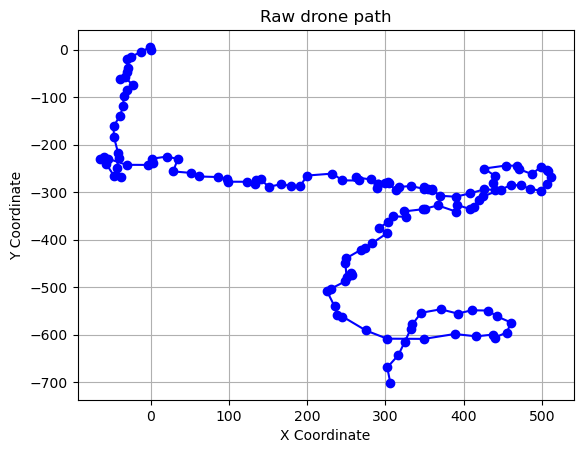

In [2]:
# Initialize variables to store the current position
x_current = 0
y_current = 0

# Initialize variables to store lists of coordinates
x_coords = [x_current]  # Start at x0 = 0
y_coords = [y_current]  # Start at y0 = 0

# Load lidar data and odometry values from drone_log.jsonl
lidar_data = []
odometry_x = []
odometry_y = []

for step in sensor_data:
    delta_x = step['odometry_x']
    delta_y = step['odometry_y']
    lidar_data.append(step['lidar'])
    odometry_x.append(delta_x)
    odometry_y.append(delta_y)    

    # Update the current position
    x_current += delta_x
    y_current += delta_y
        
    # Append the new coordinates to the lists
    x_coords.append(x_current)
    y_coords.append(y_current)

# Plot the line
plt.plot(x_coords, y_coords, color='blue', linestyle='-', marker='o')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Raw drone path')
plt.grid(True)
plt.show()

Let's visualize lidar's measurements on map

In [3]:
# Define a function to convert polar coordinates to Cartesian coordinates
def polar_to_cartesian(distance, angle):
    x = distance * math.cos(math.radians(angle))
    y = -1 * distance * math.sin(math.radians(angle))
    return x, y

# Initialize the drone's initial position
approx_start_drone_position = [300.0, 40.0]
drone_positions = []

# Simulate the movement of the drone using lidar data and odometry values
lidar_points = []
for lidar_scan, x, y in zip(lidar_data, odometry_x, odometry_y):
    
    # Update drone position
    approx_start_drone_position[0] += x
    approx_start_drone_position[1] -= y
    
    # Convert lidar data to Cartesian coordinates and update drone position
    for idx, distance in enumerate(lidar_scan):
        angle = idx * 10 % 360  # Calculate angle based on lidar index
        if 0 <= distance <= 200:  # Ensure valid lidar data
            x1, y1 = polar_to_cartesian(distance, angle)
            lidar_points.append([x1 + approx_start_drone_position[0], y1 + approx_start_drone_position[1], 0.0])
            
# Create point cloud from lidar measurements
lidar_pc = o3d.geometry.PointCloud()
lidar_pc.points = o3d.utility.Vector3dVector(lidar_points)
lidar_pc.paint_uniform_color([1, 0, 0])

# Reverse the order of the lines
map_lines_reversed = map_lines[::-1]

# Convert the reversed lines to map data
map_data_rev = [[int(value) for value in line.strip()] for line in map_lines_reversed]

# Convert the map data into a numpy array
map_array = np.array(map_data_rev)

# Convert map data to point cloud
map_points = []
for i in range(map_array.shape[0]):
    for j in range(map_array.shape[1]):
        if map_array[i, j] == 0:  # Free space
            map_points.append([j, i, 0.0])  # Assuming Z coordinate is 0 for the map
                           
# Create point cloud for the map
map_pc = o3d.geometry.PointCloud()
map_pc.points = o3d.utility.Vector3dVector(map_points)

# Visualize the lidar data and the map
o3d.visualization.draw_geometries([lidar_pc, map_pc])

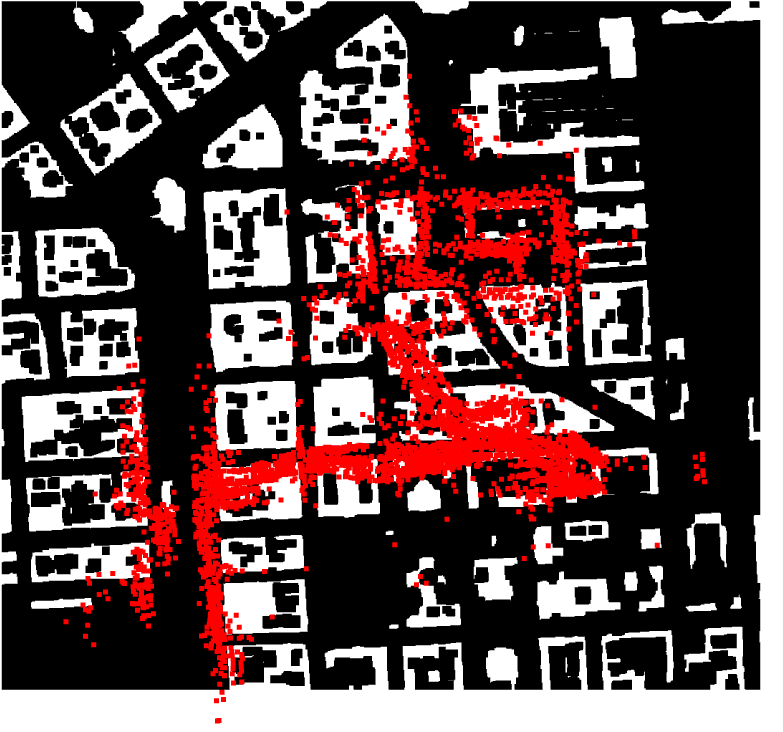

Now we need to be sure where the lidar is pointing

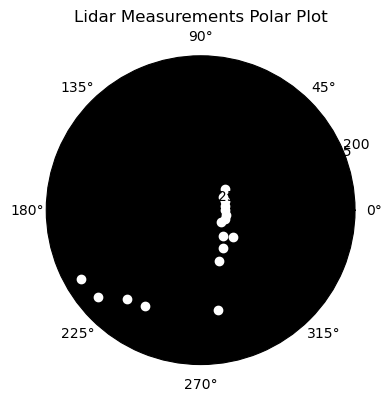

In [4]:
def polar_plot(lidar_measurements):
    # Calculate angles for each measurement (in degrees)
    angles_degrees = np.arange(0, 360, 10)  # 36 angles in total
    
    # Filter out invalid measurements
    valid_measurements = [m for m in lidar_measurements if m != -1]
    valid_angles = [angle for angle, m in zip(angles_degrees, lidar_measurements) if m != -1]
    
    # Create the polar plot
    fig = plt.figure(figsize=(4.01, 4.01)) 
    ax = fig.add_subplot(111, polar=True)  # Create a polar subplot
        
    # Plot lidar measurements
    ax.scatter(np.deg2rad(valid_angles), valid_measurements, color='white', marker='o')  # White points
    ax.set_ylim(0, 200)
    ax.set_facecolor('black')  
    ax.grid(False)  
    ax.set_title('Lidar Measurements Polar Plot')
    plt.show()
    
# Polar plot for the start point
start_lidar = sensor_data[0]['lidar']
polar_plot(start_lidar)    

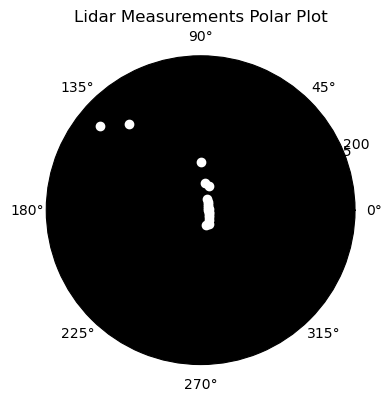

In [13]:
approx_start_drone_position = [300.0, 40.0]
approx_lidar_start = observation_model(approx_start_drone_position[0],approx_start_drone_position[1])
polar_plot(approx_lidar_start)   

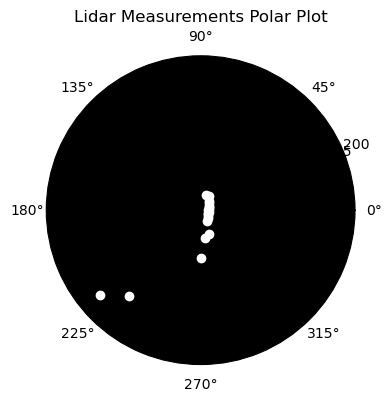

In [6]:
# Flip lidar vertically
lidar_mes_0 = [approx_lidar_start[0]]
lidar_rest = approx_lidar_start[1:]
lidar_rest = lidar_rest[::-1]
lidar_approx_start_flipped = lidar_mes_0 + lidar_rest
polar_plot(lidar_approx_start_flipped) 

For finding error between input lidar's measurements and calculated lidar's measurements we need to reverse the list of measurements as it showed above, keeping 0 angle measurement on the same position.

In [7]:
#Define function for finding point with minimum error in lidar's measurements
def min_error(start_x, end_x, start_y, end_y, lidar_from_input):

    min_error_position = {'error': float('inf')}
    for x in range(start_x, end_x):
        for y in range(start_y, end_y):
            if 0 <= x < wi and 0 <= y < he and omap[y,x] == 0:
                
                lidar_meas = observation_model(x, y)
                lidar_mes_angle0 = [lidar_meas[0]]   #leave 0 angle measurement at index 0
                lidar_rest_angles = lidar_meas[1:]   #all measurements but in 0 angle
                lidar_rest_angles = lidar_rest_angles[::-1]
                lidar_measurements = lidar_mes_angle0 + lidar_rest_angles 
                error = np.sum((np.array(lidar_from_input) - np.array(lidar_measurements)) ** 2)
                
                if error < min_error_position['error']:
                    min_error_position['error'] = error
                    min_error_position['x'] = x
                    min_error_position['y'] = y
                    min_error_position['lidar_meas'] = lidar_measurements
                    
    return min_error_position

Let's find the start point and the last point of the drone's path. As we have visualized the drone's path on the map, we understand the approximate area on map for start point and end point. However it has been checked also on the whole map and I have received the same result.


In [8]:
#check where is the start point of the drone's path
first_lidar = sensor_data[0]['lidar']
result_start = min_error(270, 280, 30 ,40, first_lidar)  
print('First point: ', result_start['x'], result_start['y'])

#check where is the end point of the drone's path
last_lidar = sensor_data[-1]['lidar']
result_last_point = min_error(600, 610, 730 ,740, last_lidar)
print('Last point: ', result_last_point['x'], result_last_point['y'])

First point:  279 36
Last point:  608 737


After finding start point let's find the drone's path.

In [9]:
# The start point of the drone's path
x_current = result_start['x']
y_current = result_start['y']
lidar_measurements = result_start['lidar_meas']

x_coords = [x_current]                               # drone's path
y_coords = [y_current]                               # drone's path
st_dev_odometry = 2 * sqrt(NOISE_VARIANCE_ODOMETRY)  #95% of values
cur_st_dev = 0                                       #cumulative error of odometries 

# function to define approximate a straight line between two given points 
def bresenham_line(x0, y0, x1, y1):
    points = []
    dx = abs(x1 - x0) 
    dy = abs(y1 - y0)
    x = x0
    y = y0
    sx = -1 if x0 > x1 else 1  
    sy = -1 if y0 > y1 else 1

    if dx > dy:
        err = dx / 2.0
        while x != x1:
            points.append((x, y))
            err -= dy
            if err < 0:
                y += sy
                err += dx
            x += sx
    else:
        err = dy / 2.0
        while y != y1:
            points.append((x, y))
            err -= dx
            if err < 0:
                x += sx
                err += dy
            y += sy

    points.append((x, y))
    return points

def check_line_on_map(map_data, line_points):
    x_right = line_points[0][0]
    y_right = line_points[0][1]
    for point in line_points:
        x, y = point
        
        if map_data[y][x] == 0:
            x_right = x
            y_right = y
        else:
            break                 # if it is an object
    return x_right, y_right

for frame in sensor_data[1:]:
    odometry_x = frame['odometry_x']
    odometry_y = frame['odometry_y']
    odometry_y = -1 * odometry_y
    lidar_data = frame['lidar']
    
    
    #Make a move
    x_current = x_current + odometry_x
    y_current = y_current + odometry_y

    # take into account noise
    start_x = int(x_current - st_dev_odometry)
    end_x = int(x_current + st_dev_odometry)
    start_y = int(y_current - st_dev_odometry)
    end_y = int(y_current + st_dev_odometry)


    # Check if the drone's path doesn't go through objects:
    line_points = bresenham_line(start_x, start_y, end_x, end_y)
    is_clear = check_line_on_map(omap, line_points)
    end_x = is_clear[0]
    end_y = is_clear[1]
    
    # Find the best suitable point
    current_result = min_error(start_x, end_x, start_y, end_y, lidar_data)
    
    cur_st_dev += st_dev_odometry    #accumulate current noise
    if cur_st_dev > 80:
        cur_st_dev = 80              

    # handle outliers 
    if current_result != {'error': float('inf')}:
        x_current = current_result['x']
        y_current = current_result['y']
    else:
        current_result = min_error(int(start_x - cur_st_dev), int(end_x + cur_st_dev), int(start_y - cur_st_dev), int(end_y + cur_st_dev), lidar_data)
        x_current = current_result['x']
        y_current = current_result['y']
            
    x_coords.append(x_current)
    y_coords.append(y_current)    

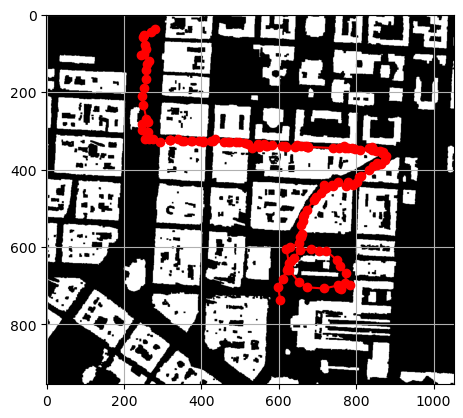

In [10]:
# Visualizing drone path on the map
plt.imshow(omap, cmap='gray')
plt.plot(x_coords, y_coords, marker='o', color='r', linestyle='-')
plt.grid(True)

The path looks good similar to open3d cloud points visualization. But we still need to match it with our png map.

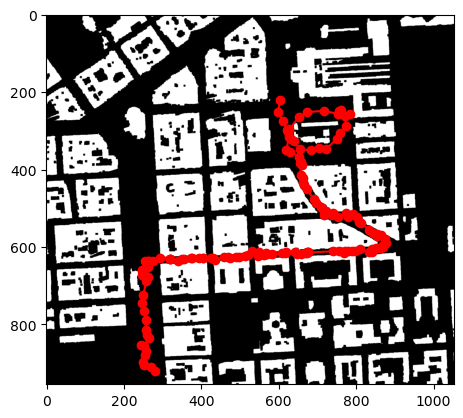

In [11]:
import matplotlib.image as mpimg

# Load and display the image
img = mpimg.imread('map_stadi_bg.png')
plt.imshow(img, cmap='gray', origin='upper')

# Invert y-coordinates to match the coordinate system
y_coords_inv = omap.shape[0] - np.array(y_coords)  # Subtracting from the height of the map

# Plot the drone path
plt.plot(x_coords, y_coords_inv, marker='o', color='r', linestyle='-')
plt.show()

In [12]:
# Specify the file path to save the CSV file
csv_file_path = 'drone_path.csv'

# Write x_coords and y_coords to the CSV file
with open(csv_file_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['x', 'y'])  # Write header
    for x, y in zip(x_coords, y_coords_inv):
        csv_writer.writerow([x, y])

print(f"CSV file saved successfully at {csv_file_path}")

CSV file saved successfully at drone_path.csv
